# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

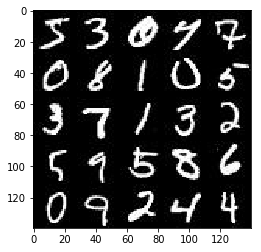

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

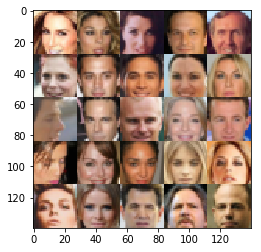

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.12.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input')
    z_data = tf.placeholder(tf.float32, [None, z_dim], name = 'z_data')
    learning_rate = tf.placeholder(tf.float32, name = 'learning_rate')

    return inputs, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [37]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.1
    keep_prob = 0.8
    
    # Trying to keep layers close to https://arxiv.org/pdf/1511.06434.pdf
    with tf.variable_scope("discriminator", reuse=reuse):
        #28->14
        conv_1 = tf.layers.conv2d(images,64,5,strides=2,padding='same',activation=None)
        lrelu_1 = tf.maximum(alpha*conv_1,conv_1)
        lrelu_1 = tf.nn.dropout(lrelu_1, keep_prob=keep_prob)
        
        #14->7
        conv_2 = tf.layers.conv2d(lrelu_1,128,5,strides=2,padding='same',activation=None)
        conv_2 = tf.layers.batch_normalization(conv_2, training=True)
        lrelu_2 = tf.maximum(alpha*conv_2,conv_2)
        lrelu_2 = tf.nn.dropout(lrelu_2, keep_prob=keep_prob)
        
        #7->4
        conv_3 = tf.layers.conv2d(lrelu_2,256,5,strides=2,padding='same',activation=None)
        conv_3 = tf.layers.batch_normalization(conv_3, training=True)
        lrelu_3 = tf.maximum(alpha*conv_3,conv_3)
        lrelu_3 = tf.nn.dropout(lrelu_3, keep_prob=keep_prob)
        
        pool_flat = tf.reshape(lrelu_3,(-1,4*4*256))
        logits = tf.layers.dense(pool_flat,1)
        output = tf.sigmoid(logits)

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [38]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    alpha = 0.1
    keep_prob = 0.8
    reuse = not is_train
    
    with tf.variable_scope("generator", reuse=reuse):
        #dense ->1024
        fc_0 = tf.layers.dense(z,4*4*1024,use_bias=False)
        fc_0 = tf.reshape(fc_0,(-1, 4,4,1024))
        fc_0 = tf.layers.batch_normalization(fc_0, training=is_train)
        lrelu_0 = tf.maximum(alpha*fc_0, fc_0)
        lrelu_0 = tf.nn.dropout(lrelu_0,keep_prob = keep_prob)
        
        #deconv 1024->512
        deconv_1 = tf.layers.conv2d_transpose(lrelu_0,512,4,strides=1,padding='valid',activation=None)
        deconv_1 = tf.layers.batch_normalization(deconv_1, training=is_train)
        lrelu_1 = tf.maximum(alpha*deconv_1, deconv_1)
        lrelu_1 = tf.nn.dropout(lrelu_1,keep_prob = keep_prob)
        
        #deconv 512->256
        deconv_2 = tf.layers.conv2d_transpose(lrelu_1,256,5,strides=2,padding='same',activation=None)
        deconv_2 = tf.layers.batch_normalization(deconv_2, training=is_train)
        lrelu_2 = tf.maximum(alpha*deconv_2, deconv_2)
        lrelu_2 = tf.nn.dropout(lrelu_2,keep_prob = keep_prob)
        
        #deconv  256->outdim
        logits = tf.layers.conv2d_transpose(lrelu_2,out_channel_dim,5,strides=2,padding='same',activation=None)
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [39]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth = 0.1
    
    #generator
    generator_output = generator(input_z,out_channel_dim)
    
    #discriminator
    discriminator_realImg_output, discriminator_realImg_logits = discriminator(input_real)
    discriminator_fakeImg_output, discriminator_fakeImg_logits = discriminator(generator_output, reuse=True)
    
    #calc loss
    discriminator_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = discriminator_realImg_logits,
            labels = tf.ones_like(discriminator_realImg_output) * (1 - smooth) ))
    discriminator_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = discriminator_fakeImg_logits,
            labels = tf.zeros_like(discriminator_fakeImg_output) ))
    generator_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = discriminator_fakeImg_logits,
            labels = tf.ones_like(discriminator_fakeImg_output) ))
    discriminiator_total_loss = discriminator_real_loss+discriminator_fake_loss
    
    return discriminiator_total_loss, generator_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [40]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    trainable_vars = tf.trainable_variables()
    discriminator_vars = [var for var in trainable_vars if var.name.startswith('discriminator')]
    generator_vars = [var for var in trainable_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

    with tf.control_dependencies(update_ops):
        generator_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=generator_vars)
        discriminator_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=discriminator_vars)
    
    return discriminator_train_opt, generator_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [41]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [42]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    disc_loss, gen_loss = model_loss(input_real, input_z, image_channels)
    disc_opt, gen_opt = model_opt(disc_loss, gen_loss, lr, beta1)

    
    saver = tf.train.Saver()
    losses = []
    steps = 0
    total_steps = epoch_count * batch_size
    
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True

    
    with tf.Session(config=config) as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                sess.run(disc_opt,feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                sess.run(gen_opt,feed_dict={input_real: batch_images, input_z: batch_z,lr:learning_rate})
                
                if steps == 1:
                    print('initial output:')
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)
                    
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = disc_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = gen_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                            "Generator Loss: {:.4f}".format(train_loss_g),
                            "Discriminator Loss: {:.4f}...".format(train_loss_d))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)
            saver.save(sess, './generator.ckpt')
        return losses
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

initial output:


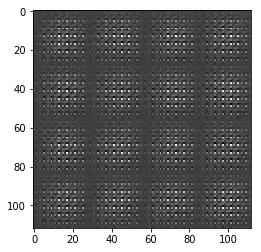

Epoch 1/2... Generator Loss: 2.2747 Discriminator Loss: 0.5839...
Epoch 1/2... Generator Loss: 1.5938 Discriminator Loss: 0.8065...
Epoch 1/2... Generator Loss: 5.4225 Discriminator Loss: 0.5847...
Epoch 1/2... Generator Loss: 3.5014 Discriminator Loss: 0.6033...
Epoch 1/2... Generator Loss: 3.3349 Discriminator Loss: 0.5331...
Epoch 1/2... Generator Loss: 2.1407 Discriminator Loss: 0.9817...
Epoch 1/2... Generator Loss: 4.3749 Discriminator Loss: 0.4671...
Epoch 1/2... Generator Loss: 5.3074 Discriminator Loss: 0.4020...
Epoch 1/2... Generator Loss: 2.4783 Discriminator Loss: 0.5268...
Epoch 1/2... Generator Loss: 3.2668 Discriminator Loss: 0.4998...


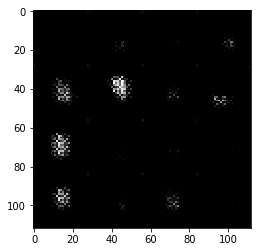

Epoch 1/2... Generator Loss: 3.4478 Discriminator Loss: 0.5435...
Epoch 1/2... Generator Loss: 3.4080 Discriminator Loss: 0.4839...
Epoch 1/2... Generator Loss: 4.3258 Discriminator Loss: 0.4489...
Epoch 1/2... Generator Loss: 1.7578 Discriminator Loss: 0.9183...
Epoch 1/2... Generator Loss: 1.9619 Discriminator Loss: 0.7988...
Epoch 1/2... Generator Loss: 2.0345 Discriminator Loss: 0.7345...
Epoch 1/2... Generator Loss: 1.9541 Discriminator Loss: 0.7385...
Epoch 1/2... Generator Loss: 2.8775 Discriminator Loss: 0.8558...
Epoch 1/2... Generator Loss: 2.5928 Discriminator Loss: 0.6417...
Epoch 1/2... Generator Loss: 2.4442 Discriminator Loss: 0.6218...


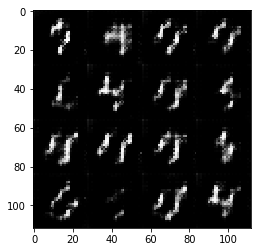

Epoch 1/2... Generator Loss: 1.7291 Discriminator Loss: 0.9776...
Epoch 1/2... Generator Loss: 1.8666 Discriminator Loss: 0.7594...
Epoch 1/2... Generator Loss: 3.1602 Discriminator Loss: 0.8296...
Epoch 2/2... Generator Loss: 2.0938 Discriminator Loss: 0.8192...
Epoch 2/2... Generator Loss: 1.0334 Discriminator Loss: 1.2629...
Epoch 2/2... Generator Loss: 2.1356 Discriminator Loss: 0.9468...
Epoch 2/2... Generator Loss: 2.8895 Discriminator Loss: 0.6203...
Epoch 2/2... Generator Loss: 3.0129 Discriminator Loss: 0.7756...
Epoch 2/2... Generator Loss: 2.7231 Discriminator Loss: 0.8011...
Epoch 2/2... Generator Loss: 2.5972 Discriminator Loss: 0.6935...


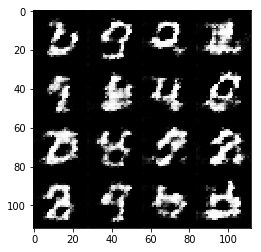

Epoch 2/2... Generator Loss: 2.2960 Discriminator Loss: 0.6968...
Epoch 2/2... Generator Loss: 1.0373 Discriminator Loss: 1.0695...
Epoch 2/2... Generator Loss: 2.6510 Discriminator Loss: 0.8317...
Epoch 2/2... Generator Loss: 2.0021 Discriminator Loss: 0.6832...
Epoch 2/2... Generator Loss: 1.1061 Discriminator Loss: 1.0757...
Epoch 2/2... Generator Loss: 2.1017 Discriminator Loss: 1.0323...
Epoch 2/2... Generator Loss: 1.5540 Discriminator Loss: 0.8402...
Epoch 2/2... Generator Loss: 1.5558 Discriminator Loss: 0.9550...
Epoch 2/2... Generator Loss: 1.3487 Discriminator Loss: 0.9490...
Epoch 2/2... Generator Loss: 2.5947 Discriminator Loss: 1.0954...


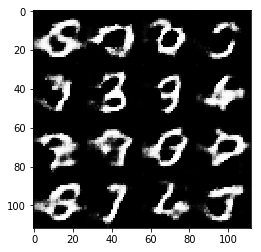

Epoch 2/2... Generator Loss: 1.6855 Discriminator Loss: 0.9324...
Epoch 2/2... Generator Loss: 1.8122 Discriminator Loss: 0.8539...
Epoch 2/2... Generator Loss: 2.3044 Discriminator Loss: 0.8758...
Epoch 2/2... Generator Loss: 1.0516 Discriminator Loss: 1.0578...
Epoch 2/2... Generator Loss: 2.1406 Discriminator Loss: 0.9209...
Epoch 2/2... Generator Loss: 0.6937 Discriminator Loss: 1.4729...


In [44]:
batch_size = 2**8 #2**7 Generator Loss: 1.4744 Discriminator Loss: 1.3444
                # 2**8 Generator Loss: 1.3906 Discriminator Loss: 1.2027
z_dim = 100
learning_rate = 0.0005 #0.005 Generator Loss: 1.5543 Discriminator Loss: 1.0928
beta1 = 0.6 #0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

initial output:


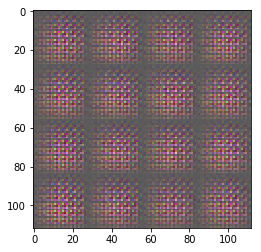

Epoch 1/1... Generator Loss: 1.2026 Discriminator Loss: 0.9519...
Epoch 1/1... Generator Loss: 6.2712 Discriminator Loss: 0.5627...
Epoch 1/1... Generator Loss: 1.8593 Discriminator Loss: 0.6593...
Epoch 1/1... Generator Loss: 3.9296 Discriminator Loss: 0.5309...
Epoch 1/1... Generator Loss: 2.5779 Discriminator Loss: 0.5566...
Epoch 1/1... Generator Loss: 5.2050 Discriminator Loss: 0.5625...
Epoch 1/1... Generator Loss: 7.5576 Discriminator Loss: 0.6681...
Epoch 1/1... Generator Loss: 3.8317 Discriminator Loss: 0.5907...
Epoch 1/1... Generator Loss: 3.6794 Discriminator Loss: 0.5333...
Epoch 1/1... Generator Loss: 4.0870 Discriminator Loss: 0.4313...


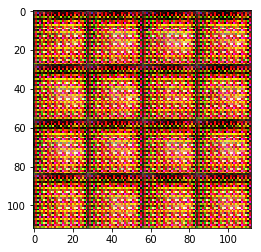

Epoch 1/1... Generator Loss: 4.1695 Discriminator Loss: 0.4280...
Epoch 1/1... Generator Loss: 1.8988 Discriminator Loss: 0.6068...
Epoch 1/1... Generator Loss: 4.5296 Discriminator Loss: 0.4862...
Epoch 1/1... Generator Loss: 4.3161 Discriminator Loss: 0.4165...
Epoch 1/1... Generator Loss: 3.4208 Discriminator Loss: 0.4640...
Epoch 1/1... Generator Loss: 3.1838 Discriminator Loss: 0.4602...
Epoch 1/1... Generator Loss: 3.3080 Discriminator Loss: 0.4714...
Epoch 1/1... Generator Loss: 3.0625 Discriminator Loss: 0.5335...
Epoch 1/1... Generator Loss: 2.5898 Discriminator Loss: 0.5450...
Epoch 1/1... Generator Loss: 3.7390 Discriminator Loss: 0.4541...


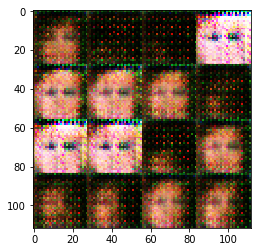

Epoch 1/1... Generator Loss: 3.8566 Discriminator Loss: 0.5566...
Epoch 1/1... Generator Loss: 3.1027 Discriminator Loss: 0.4608...
Epoch 1/1... Generator Loss: 5.0400 Discriminator Loss: 1.0769...
Epoch 1/1... Generator Loss: 2.4511 Discriminator Loss: 0.5480...
Epoch 1/1... Generator Loss: 4.2262 Discriminator Loss: 1.0884...
Epoch 1/1... Generator Loss: 5.6573 Discriminator Loss: 0.7371...
Epoch 1/1... Generator Loss: 1.2776 Discriminator Loss: 1.0743...
Epoch 1/1... Generator Loss: 2.1380 Discriminator Loss: 0.6922...
Epoch 1/1... Generator Loss: 2.5996 Discriminator Loss: 0.5364...
Epoch 1/1... Generator Loss: 1.6783 Discriminator Loss: 0.8195...


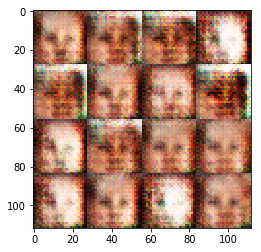

Epoch 1/1... Generator Loss: 1.7671 Discriminator Loss: 0.7424...
Epoch 1/1... Generator Loss: 1.4583 Discriminator Loss: 0.7506...
Epoch 1/1... Generator Loss: 2.3068 Discriminator Loss: 0.7562...
Epoch 1/1... Generator Loss: 2.0805 Discriminator Loss: 0.6859...
Epoch 1/1... Generator Loss: 2.2248 Discriminator Loss: 0.6564...
Epoch 1/1... Generator Loss: 0.9962 Discriminator Loss: 1.3421...
Epoch 1/1... Generator Loss: 1.6607 Discriminator Loss: 0.8443...
Epoch 1/1... Generator Loss: 0.5543 Discriminator Loss: 1.5507...
Epoch 1/1... Generator Loss: 2.0989 Discriminator Loss: 0.7673...
Epoch 1/1... Generator Loss: 1.5905 Discriminator Loss: 0.8955...


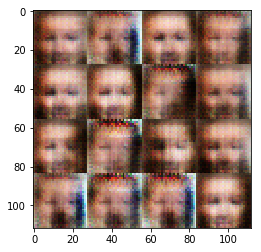

Epoch 1/1... Generator Loss: 1.7992 Discriminator Loss: 1.0616...
Epoch 1/1... Generator Loss: 1.5704 Discriminator Loss: 0.7906...
Epoch 1/1... Generator Loss: 1.7045 Discriminator Loss: 0.9120...
Epoch 1/1... Generator Loss: 1.2954 Discriminator Loss: 0.9452...
Epoch 1/1... Generator Loss: 1.1118 Discriminator Loss: 1.0275...
Epoch 1/1... Generator Loss: 1.6069 Discriminator Loss: 0.9455...
Epoch 1/1... Generator Loss: 2.0066 Discriminator Loss: 0.7991...
Epoch 1/1... Generator Loss: 1.2632 Discriminator Loss: 0.9918...
Epoch 1/1... Generator Loss: 1.9374 Discriminator Loss: 1.0934...
Epoch 1/1... Generator Loss: 2.7389 Discriminator Loss: 1.1643...


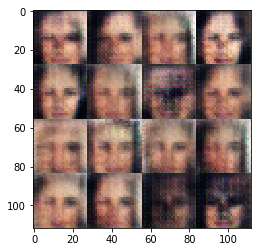

Epoch 1/1... Generator Loss: 1.3054 Discriminator Loss: 1.1069...
Epoch 1/1... Generator Loss: 0.9580 Discriminator Loss: 1.1952...
Epoch 1/1... Generator Loss: 1.9498 Discriminator Loss: 0.7757...
Epoch 1/1... Generator Loss: 1.6232 Discriminator Loss: 1.1112...
Epoch 1/1... Generator Loss: 1.9319 Discriminator Loss: 0.8570...
Epoch 1/1... Generator Loss: 1.9286 Discriminator Loss: 0.8134...
Epoch 1/1... Generator Loss: 1.5963 Discriminator Loss: 0.8130...
Epoch 1/1... Generator Loss: 1.8944 Discriminator Loss: 0.7560...
Epoch 1/1... Generator Loss: 1.4338 Discriminator Loss: 0.9165...
Epoch 1/1... Generator Loss: 2.6440 Discriminator Loss: 1.1313...


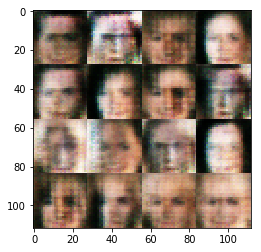

Epoch 1/1... Generator Loss: 2.2537 Discriminator Loss: 0.6676...
Epoch 1/1... Generator Loss: 2.2221 Discriminator Loss: 1.1230...
Epoch 1/1... Generator Loss: 1.7331 Discriminator Loss: 0.8371...
Epoch 1/1... Generator Loss: 1.0178 Discriminator Loss: 1.0798...
Epoch 1/1... Generator Loss: 1.5251 Discriminator Loss: 0.7556...
Epoch 1/1... Generator Loss: 1.1957 Discriminator Loss: 1.0373...
Epoch 1/1... Generator Loss: 2.1373 Discriminator Loss: 0.8839...
Epoch 1/1... Generator Loss: 1.5397 Discriminator Loss: 0.8502...
Epoch 1/1... Generator Loss: 1.6716 Discriminator Loss: 0.9196...
Epoch 1/1... Generator Loss: 1.8972 Discriminator Loss: 1.0112...


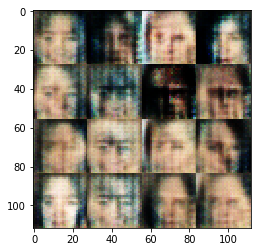

Epoch 1/1... Generator Loss: 1.6251 Discriminator Loss: 0.9762...
Epoch 1/1... Generator Loss: 2.1452 Discriminator Loss: 1.0720...
Epoch 1/1... Generator Loss: 1.8629 Discriminator Loss: 0.8683...
Epoch 1/1... Generator Loss: 3.3387 Discriminator Loss: 1.1877...
Epoch 1/1... Generator Loss: 1.0054 Discriminator Loss: 1.1655...
Epoch 1/1... Generator Loss: 1.8932 Discriminator Loss: 0.7771...
Epoch 1/1... Generator Loss: 1.4557 Discriminator Loss: 0.8043...
Epoch 1/1... Generator Loss: 2.1332 Discriminator Loss: 0.7994...
Epoch 1/1... Generator Loss: 1.2637 Discriminator Loss: 0.9302...
Epoch 1/1... Generator Loss: 1.5529 Discriminator Loss: 0.8913...


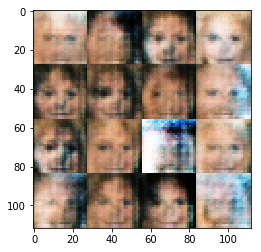

Epoch 1/1... Generator Loss: 1.7810 Discriminator Loss: 0.8535...
Epoch 1/1... Generator Loss: 1.0486 Discriminator Loss: 1.0327...
Epoch 1/1... Generator Loss: 2.7537 Discriminator Loss: 0.8225...
Epoch 1/1... Generator Loss: 1.5986 Discriminator Loss: 0.8886...
Epoch 1/1... Generator Loss: 1.4574 Discriminator Loss: 0.8605...
Epoch 1/1... Generator Loss: 1.8985 Discriminator Loss: 0.7636...
Epoch 1/1... Generator Loss: 1.6593 Discriminator Loss: 1.0275...
Epoch 1/1... Generator Loss: 0.7857 Discriminator Loss: 1.3156...
Epoch 1/1... Generator Loss: 1.4706 Discriminator Loss: 0.8534...
Epoch 1/1... Generator Loss: 1.6498 Discriminator Loss: 0.7841...


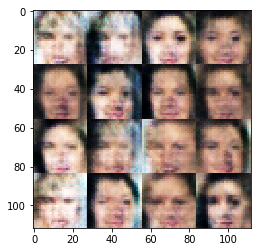

Epoch 1/1... Generator Loss: 1.3460 Discriminator Loss: 1.0967...
Epoch 1/1... Generator Loss: 1.6963 Discriminator Loss: 0.8120...
Epoch 1/1... Generator Loss: 1.2418 Discriminator Loss: 0.9346...
Epoch 1/1... Generator Loss: 1.5745 Discriminator Loss: 0.8476...
Epoch 1/1... Generator Loss: 1.3262 Discriminator Loss: 1.1418...
Epoch 1/1... Generator Loss: 2.7486 Discriminator Loss: 0.9333...
Epoch 1/1... Generator Loss: 1.5286 Discriminator Loss: 0.8440...
Epoch 1/1... Generator Loss: 1.2211 Discriminator Loss: 1.0480...
Epoch 1/1... Generator Loss: 1.0871 Discriminator Loss: 1.4405...
Epoch 1/1... Generator Loss: 1.3812 Discriminator Loss: 1.0400...


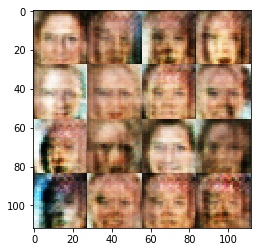

Epoch 1/1... Generator Loss: 1.5079 Discriminator Loss: 0.9539...
Epoch 1/1... Generator Loss: 0.4300 Discriminator Loss: 1.9540...
Epoch 1/1... Generator Loss: 1.3937 Discriminator Loss: 0.9047...
Epoch 1/1... Generator Loss: 1.2606 Discriminator Loss: 1.0468...
Epoch 1/1... Generator Loss: 1.1727 Discriminator Loss: 1.0307...
Epoch 1/1... Generator Loss: 1.3846 Discriminator Loss: 0.9937...
Epoch 1/1... Generator Loss: 1.0012 Discriminator Loss: 1.0621...
Epoch 1/1... Generator Loss: 0.8907 Discriminator Loss: 1.1434...
Epoch 1/1... Generator Loss: 0.8024 Discriminator Loss: 1.2265...
Epoch 1/1... Generator Loss: 0.8199 Discriminator Loss: 1.2620...


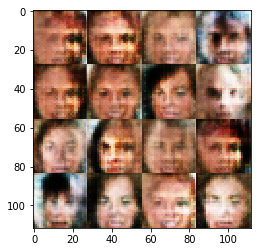

Epoch 1/1... Generator Loss: 0.9583 Discriminator Loss: 1.0942...
Epoch 1/1... Generator Loss: 1.7005 Discriminator Loss: 0.7802...
Epoch 1/1... Generator Loss: 1.5996 Discriminator Loss: 0.8726...
Epoch 1/1... Generator Loss: 1.1204 Discriminator Loss: 1.0868...
Epoch 1/1... Generator Loss: 1.6192 Discriminator Loss: 0.8483...
Epoch 1/1... Generator Loss: 1.8730 Discriminator Loss: 1.1852...
Epoch 1/1... Generator Loss: 1.1422 Discriminator Loss: 1.0031...
Epoch 1/1... Generator Loss: 1.3376 Discriminator Loss: 1.0406...
Epoch 1/1... Generator Loss: 1.5111 Discriminator Loss: 1.0022...
Epoch 1/1... Generator Loss: 1.3045 Discriminator Loss: 1.0953...


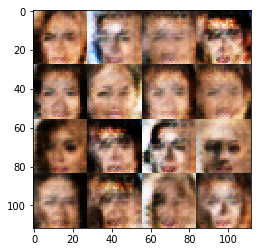

Epoch 1/1... Generator Loss: 1.6512 Discriminator Loss: 0.9124...
Epoch 1/1... Generator Loss: 2.2235 Discriminator Loss: 1.0157...
Epoch 1/1... Generator Loss: 1.3598 Discriminator Loss: 0.8525...
Epoch 1/1... Generator Loss: 2.2390 Discriminator Loss: 0.9890...
Epoch 1/1... Generator Loss: 1.2694 Discriminator Loss: 1.1572...
Epoch 1/1... Generator Loss: 1.6458 Discriminator Loss: 0.9580...
Epoch 1/1... Generator Loss: 1.2545 Discriminator Loss: 0.9975...
Epoch 1/1... Generator Loss: 2.0644 Discriminator Loss: 1.0169...
Epoch 1/1... Generator Loss: 1.6061 Discriminator Loss: 1.1644...
Epoch 1/1... Generator Loss: 1.7919 Discriminator Loss: 1.2203...


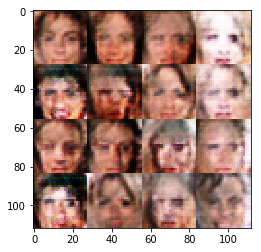

Epoch 1/1... Generator Loss: 1.4075 Discriminator Loss: 0.9514...
Epoch 1/1... Generator Loss: 0.7021 Discriminator Loss: 1.4920...
Epoch 1/1... Generator Loss: 1.8079 Discriminator Loss: 0.9191...
Epoch 1/1... Generator Loss: 1.0160 Discriminator Loss: 1.0642...
Epoch 1/1... Generator Loss: 1.3439 Discriminator Loss: 0.8365...
Epoch 1/1... Generator Loss: 1.6241 Discriminator Loss: 1.0015...
Epoch 1/1... Generator Loss: 1.6132 Discriminator Loss: 0.9550...
Epoch 1/1... Generator Loss: 1.2174 Discriminator Loss: 1.1158...
Epoch 1/1... Generator Loss: 1.3897 Discriminator Loss: 1.0409...
Epoch 1/1... Generator Loss: 1.1197 Discriminator Loss: 0.9594...


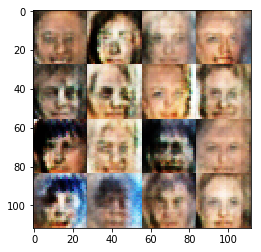

Epoch 1/1... Generator Loss: 2.2672 Discriminator Loss: 1.0441...
Epoch 1/1... Generator Loss: 1.3335 Discriminator Loss: 1.0130...
Epoch 1/1... Generator Loss: 1.3475 Discriminator Loss: 0.9312...
Epoch 1/1... Generator Loss: 1.2125 Discriminator Loss: 1.0347...
Epoch 1/1... Generator Loss: 1.1182 Discriminator Loss: 1.0583...
Epoch 1/1... Generator Loss: 1.3104 Discriminator Loss: 1.0215...
Epoch 1/1... Generator Loss: 1.8519 Discriminator Loss: 0.8241...
Epoch 1/1... Generator Loss: 2.0937 Discriminator Loss: 0.8810...
Epoch 1/1... Generator Loss: 1.7309 Discriminator Loss: 0.9592...
Epoch 1/1... Generator Loss: 1.3632 Discriminator Loss: 0.9762...


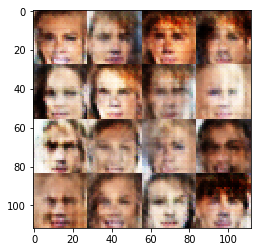

Epoch 1/1... Generator Loss: 0.8522 Discriminator Loss: 1.3251...
Epoch 1/1... Generator Loss: 1.1613 Discriminator Loss: 1.1727...
Epoch 1/1... Generator Loss: 1.7456 Discriminator Loss: 1.1686...
Epoch 1/1... Generator Loss: 1.5512 Discriminator Loss: 0.9395...
Epoch 1/1... Generator Loss: 1.0972 Discriminator Loss: 1.2118...
Epoch 1/1... Generator Loss: 1.8773 Discriminator Loss: 0.9763...
Epoch 1/1... Generator Loss: 1.3285 Discriminator Loss: 0.9820...
Epoch 1/1... Generator Loss: 1.2210 Discriminator Loss: 1.0256...


In [47]:
batch_size = 2**7
z_dim = 100
learning_rate = 0.0005
beta1 = 0.6


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.